In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [2]:
os.chdir('../data/interim')

In [3]:
os.listdir()

['joined data post-markdowns.csv',
 'joined data pre-markdowns.csv',
 '.gitkeep',
 'data post-eda.csv',
 'joined data full.csv']

### Generate Dummy Features

My approach is going to be dropping the markdown columns in order to have access to the entire data set for training.

In [94]:
# Loading full joined data as df
df = pd.read_csv('data post-eda.csv')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,2,151315,1,1


In [95]:
# Dropping markdown columns
df.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

In [96]:
# Show info of remaining columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  int64  
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  int64  
 10  Size          421570 non-null  int64  
 11  Month         421570 non-null  int64  
 12  Week          421570 non-null  int64  
dtypes: float64(5), int64(7), object(1)
memory usage: 41.8+ MB


Columns that should have dummy features encoded:
- Store
- Dept
- Type
- Month
- Week

In [97]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Month,Week
0,1,1,2010-01-10,20094.19,0,71.89,2.603,211.671989,7.838,2,151315,1,1
1,1,2,2010-01-10,45829.02,0,71.89,2.603,211.671989,7.838,2,151315,1,1
2,1,3,2010-01-10,9775.17,0,71.89,2.603,211.671989,7.838,2,151315,1,1
3,1,4,2010-01-10,34912.45,0,71.89,2.603,211.671989,7.838,2,151315,1,1
4,1,5,2010-01-10,23381.38,0,71.89,2.603,211.671989,7.838,2,151315,1,1


In [98]:
# Create dummy features
storeDummies = pd.get_dummies(df['Store'], prefix='Store', drop_first=True)
deptDummies = pd.get_dummies(df['Dept'], prefix='Dept', drop_first=True)
typeDummies = pd.get_dummies(df['Type'], prefix='Type', drop_first=True)
monthDummies = pd.get_dummies(df['Month'], prefix='Month', drop_first=True)
weekDummies = pd.get_dummies(df['Week'], prefix='Week', drop_first=True)

In [99]:
# Join dummy features onto dataframe
df1 = df.join([storeDummies, deptDummies, typeDummies, monthDummies, weekDummies])

In [100]:
# Drop original features
df1.drop(columns=['Store', 'Dept', 'Type', 'Month', 'Week'], inplace=True)

In [101]:
# Check shape
df1.shape

(421570, 196)

My current approach is to attempt to build a successful model without building a time series model. Because of this I will now drop the Date column as well.

In [12]:
# Drop Date
#df1.drop(columns='Date', inplace=True)

In [13]:
#df1.head()

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Store_2,Store_3,Store_4,...,Week_43,Week_44,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52
0,20094.19,0,71.89,2.603,211.671989,7.838,151315,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,45829.02,0,71.89,2.603,211.671989,7.838,151315,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9775.17,0,71.89,2.603,211.671989,7.838,151315,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34912.45,0,71.89,2.603,211.671989,7.838,151315,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23381.38,0,71.89,2.603,211.671989,7.838,151315,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train Test Split

We want to perform a train test split prior to scaling the data to prevent data leakage

In [102]:
trainmask = df1.Date < '2012-01-01'
testmask = df1.Date >= '2012-01-01'

In [103]:
dftrain = df1.loc[trainmask]
dftest = df1.loc[testmask]

In [104]:
X_train = dftrain.drop(columns=['Date', 'Weekly_Sales'])
y_train = dftrain[['Weekly_Sales']]
X_test = dftest.drop(columns=['Date', 'Weekly_Sales'])
y_test = dftest[['Weekly_Sales']]

In [105]:
# Import train_test_split
#from sklearn.model_selection import train_test_split

In [106]:
# Split df1 into X and Y
#X = df1.drop(columns='Weekly_Sales')
#y = df1[['Weekly_Sales']]

In [107]:
# Perform train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Apply Scaler Transformation to X_train

Check histograms of data to determine what type of scaler should be applied

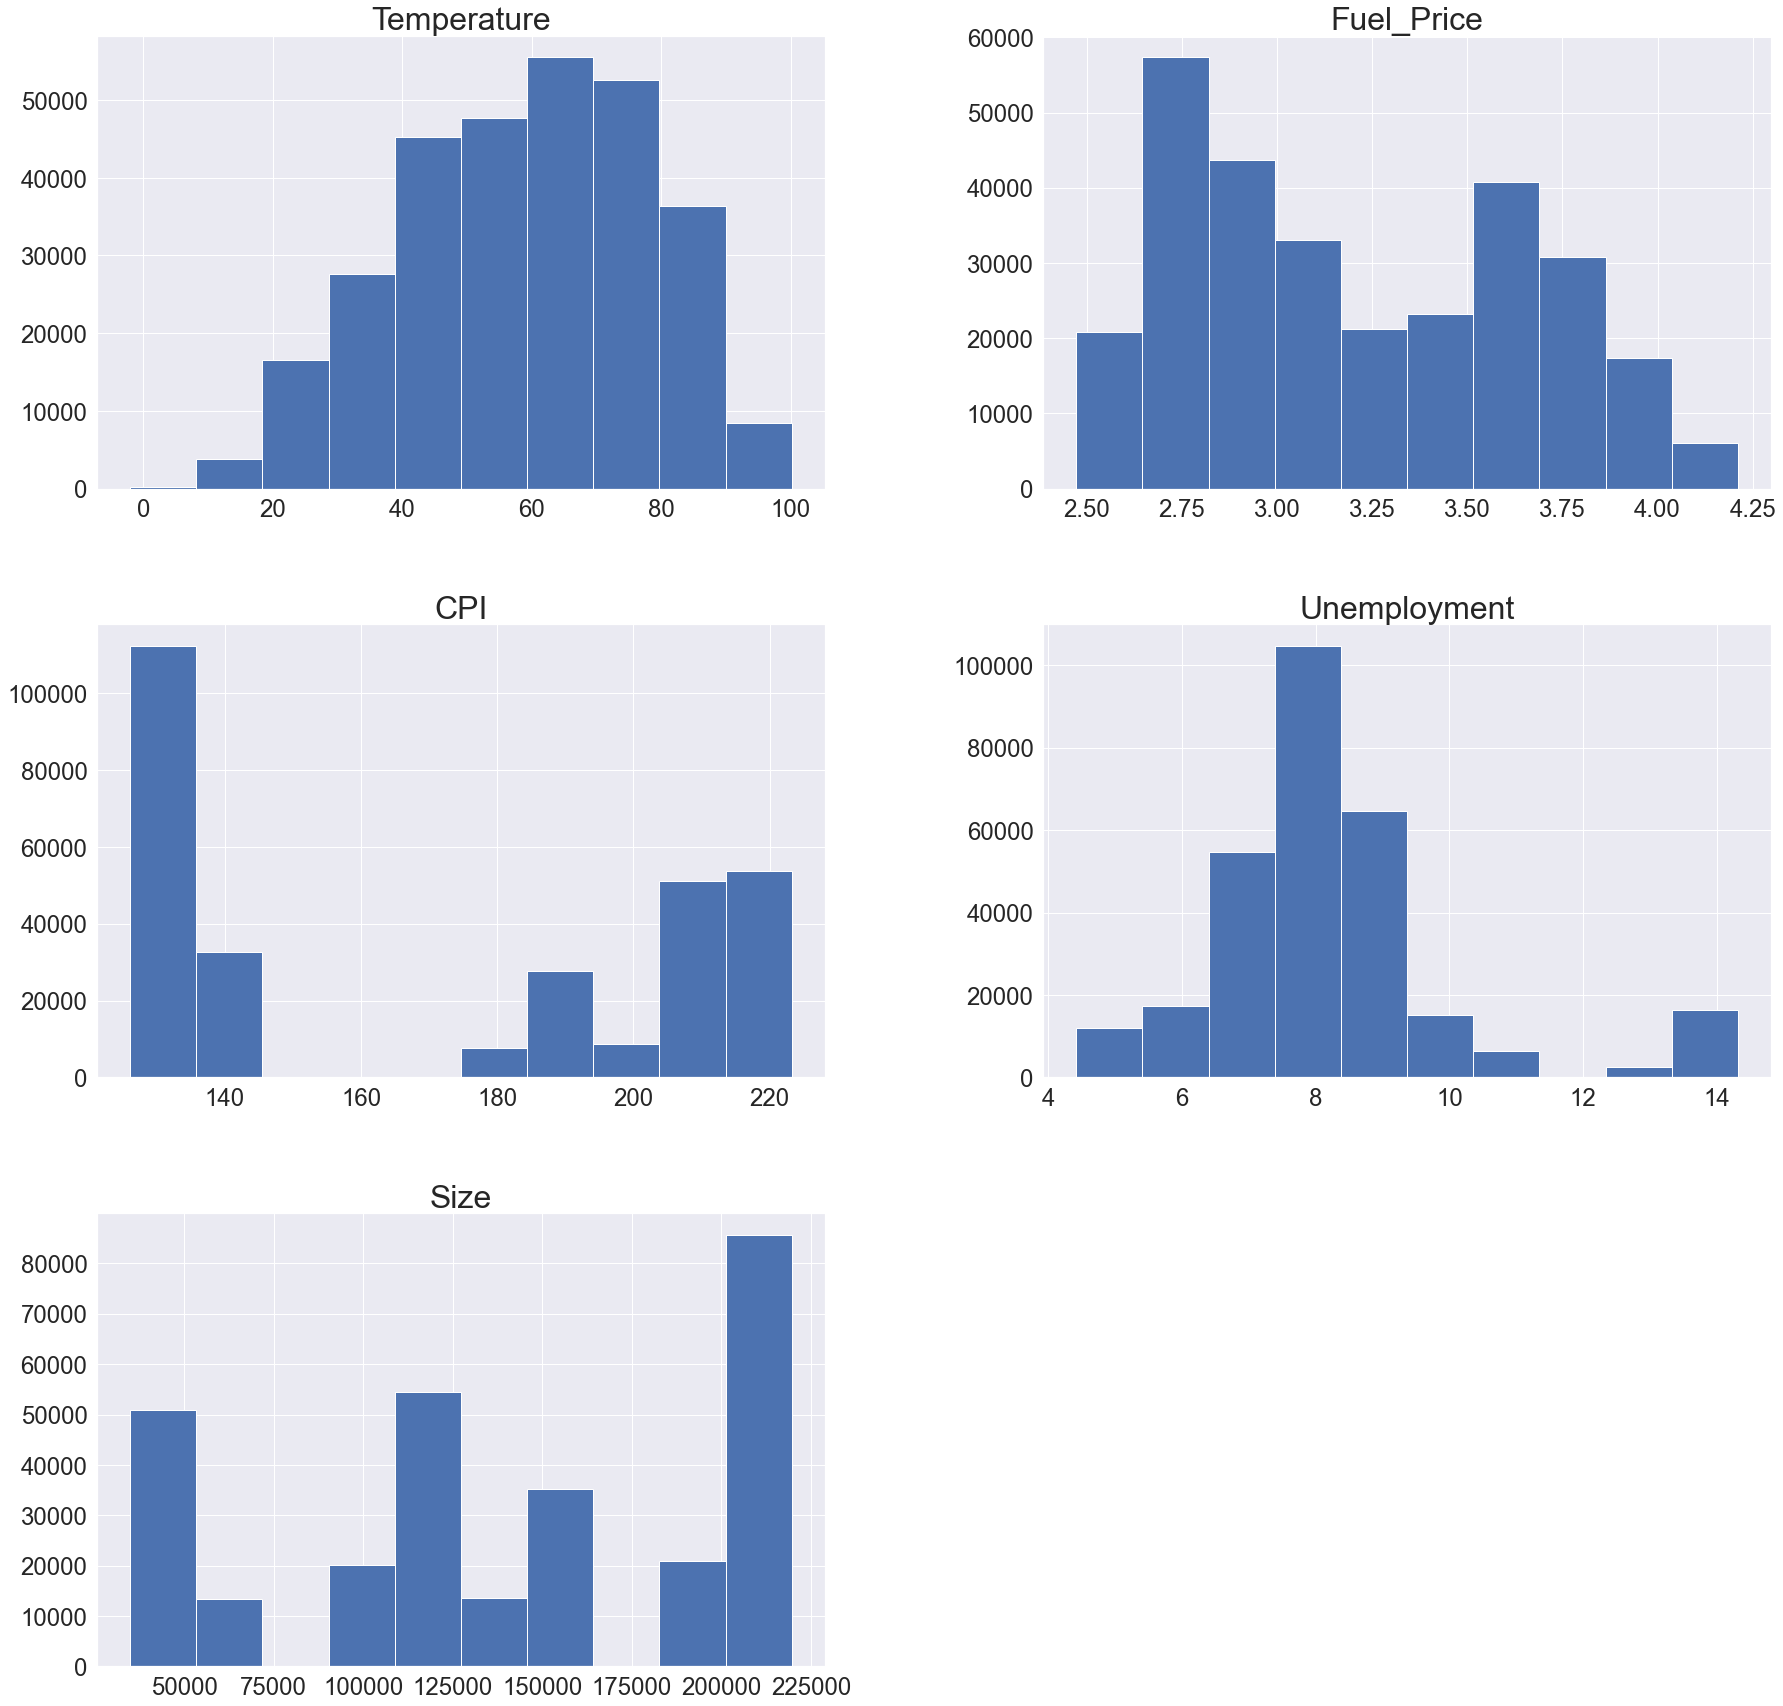

In [108]:
# Plot histograms
from matplotlib import rcParams
sns.set()
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
rcParams.update(params)
_ = X_train[['Temperature','Fuel_Price','CPI', 'Unemployment', 'Size']].hist(figsize=(30, 30))

StandardScaler should be acceptable for these.

In [109]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

In [110]:
# Initialize scaler and fit_transform X_train
scaler = StandardScaler()
X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler.fit_transform(X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

In [111]:
# Verify that tranformation was successful
X_train.head()

,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Store_2,Store_3,Store_4,Store_5,...,Week_43,Week_44,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52
0,0,0.685587,-1.381735,1.095623,-0.211499,0.236801,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.685587,-1.381735,1.095623,-0.211499,0.236801,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.685587,-1.381735,1.095623,-0.211499,0.236801,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.685587,-1.381735,1.095623,-0.211499,0.236801,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.685587,-1.381735,1.095623,-0.211499,0.236801,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Modeling

Let's try a standard linear regression to start

In [112]:
from sklearn.linear_model import LinearRegression

In [113]:
reg = LinearRegression()

In [114]:
reg.fit(X_train, y_train)

LinearRegression()

In [115]:
X_test.loc[:,['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']] = scaler.transform(X_test[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']])

In [116]:
y_pred = reg.predict(X_test)

In [117]:
reg.score(X_train, y_train)

0.6480067245743393

In [118]:
from sklearn.metrics import mean_squared_error

In [119]:
mean_squared_error(y_test, y_pred)

8.106517593628442e+30

In [120]:
from sklearn.metrics import r2_score

In [121]:
r2_score(y_test, y_pred)

-1.6567087356368097e+22

Let's try a Random Forest Regression to see if it does any better

In [37]:
# Let's try max_depth = 10
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(max_depth=10, random_state=42)
reg.fit(X_train, np.ravel(y_train))

RandomForestRegressor(max_depth=10, random_state=42)

In [38]:
y_pred = reg.predict(X_test)

In [46]:
round(reg.score(X_train, y_train), 2)

0.7

In [47]:
round(mean_squared_error(y_test, y_pred), 2)

159044739.32

In [48]:
round(r2_score(y_test, y_pred), 2)

0.69

In [49]:
# Let's try max_depth = 15
reg = RandomForestRegressor(max_depth=15, random_state=42)
reg.fit(X_train, np.ravel(y_train))

RandomForestRegressor(max_depth=15, random_state=42)

In [50]:
y_pred = reg.predict(X_test)

In [51]:
round(reg.score(X_train, y_train), 2)

0.81

In [52]:
round(mean_squared_error(y_test, y_pred), 2)

104580408.32

In [53]:
round(r2_score(y_test, y_pred), 2)

0.8

In [122]:
# Let's try max_depth = 20
reg = RandomForestRegressor(max_depth=20, random_state=42)
reg.fit(X_train, np.ravel(y_train))

RandomForestRegressor(max_depth=20, random_state=42)

In [123]:
y_pred = reg.predict(X_test)

In [124]:
round(reg.score(X_train, y_train), 2)

0.87

In [125]:
round(mean_squared_error(y_test, y_pred), 2)

75856915.57

In [126]:
round(r2_score(y_test, y_pred), 2)

0.84

In [174]:
S2mask = X_test.Store_5 == 1
D2mask = X_test.Dept_5 == 1

In [175]:
S2D2X_test = X_test.loc[S2mask].loc[D2mask]
S2D2X_testIDX = S2D2X_test.index

In [176]:
S2D2y_test = y_test.loc[S2D2X_testIDX]

In [177]:
S2D2y_pred = reg.predict(S2D2X_test)

In [178]:
round(mean_squared_error(S2D2y_test, S2D2y_pred), 2)

16650300.99

In [179]:
round(r2_score(S2D2y_test, S2D2y_pred), 2)

-6.86

*I'm not happy with how this performs on specific stores and departments. I should create different models fit by store Type.*

Let's try KNN and see how it does

In [59]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
knn = KNeighborsRegressor()

In [60]:

param_grid = {'n_neighbors':[5, 10, 15, 20, 25, 30]}
gcv = GridSearchCV(knn, param_grid)

In [61]:
gcv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [5, 10, 15, 20, 25, 30]})

*I should split the train and test data at a certain point in time rather than doing it randomly. This will simulate the type of predictive modeling this would be intended for in practice.*

In [62]:
gcv.best_estimator_

KNeighborsRegressor()

In [63]:
gcv.best_params_

{'n_neighbors': 5}

In [64]:
gcv.best_score_

0.13303730697379573

In [65]:
y_pred = gcv.predict(X_test)

In [66]:
round(reg.score(X_train, y_train), 2)

0.87

In [67]:
round(mean_squared_error(y_test, y_pred), 2)

426605450.79

In [68]:
round(r2_score(y_test, y_pred), 2)

0.18

KNN performed horribly. Definitely overfit the data. Could be due to the curse of dimensionality. Could function better on data that's had its dimensionality reduced by PCA.

Once I find a good model that works I should filter the test data by a particular store/department, run it through and then compare the y_pred vs y_test